<a href="https://colab.research.google.com/github/zamaS24/VMI_MULTIMODA/blob/master/CLIP_tutorial_(with_medical_images_ROCO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook created in 2024 with the help of Xiaoyang Wei, Phd student at LIPADE, Université Paris Cité

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-a3952usy
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-a3952usy
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=f77959b773426bfe8d42aa6ac23962fd4bb470f0d1cc28fc1092cc92069a2a14
  Stored in directory: /tmp/pip-ephem-wheel-cache-na1gz07t/wheels/35/3e/df/3d24cbfb3b6a06f17a2bfd7d1138900d4365d9028aa8f6e92f
Successfully built clip


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [2]:
import clip
import numpy as np

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load("ViT-B/16")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 335M/335M [00:07<00:00, 48.8MiB/s]


Model parameters: 149,620,737
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [4]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x79e0aa4c6660>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [5]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example natrural/medical images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [6]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# to mount google drive
if os.getcwd()=='/content':
    try:
        from google.colab import drive
        base_working_dir = '/content/drive/MyDrive'
        drive.mount('/content/drive')
    except:
        base_working_dir = os.getcwd()
        pass
!mkdir -p drive
!google-drive-ocamlfuse drive
print(base_working_dir)

Mounted at /content/drive
/bin/bash: line 1: google-drive-ocamlfuse: command not found
/content/drive/MyDrive


In [7]:
# images to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

med_descriptions = {
    "ROCO_00002": "CT scan in axial view showing obliteration of the left maxillary sinus",
    "ROCO_00017": "Coronary angiogram demonstrating occluded arteries",
    "ROCO_00028": "T2 weighted MRI image showing foraminal extensions of the cysts",
    "ROCO_00033": "Lytic lesions (arrows) involving the humerus.",
    "ROCO_00050": "Free air beneath the diaphragm at abdominal x-ray film",
    "ROCO_00056": "View of giant cell tumor of thumb metacarpal preoperatively",
    "ROCO_00060": "Transverse view of lung using CT.Leukemic infiltration is seen.",
    "ROCO_00135": "CT scan showing multiple non-communicating cysts in liver and kidney"
}

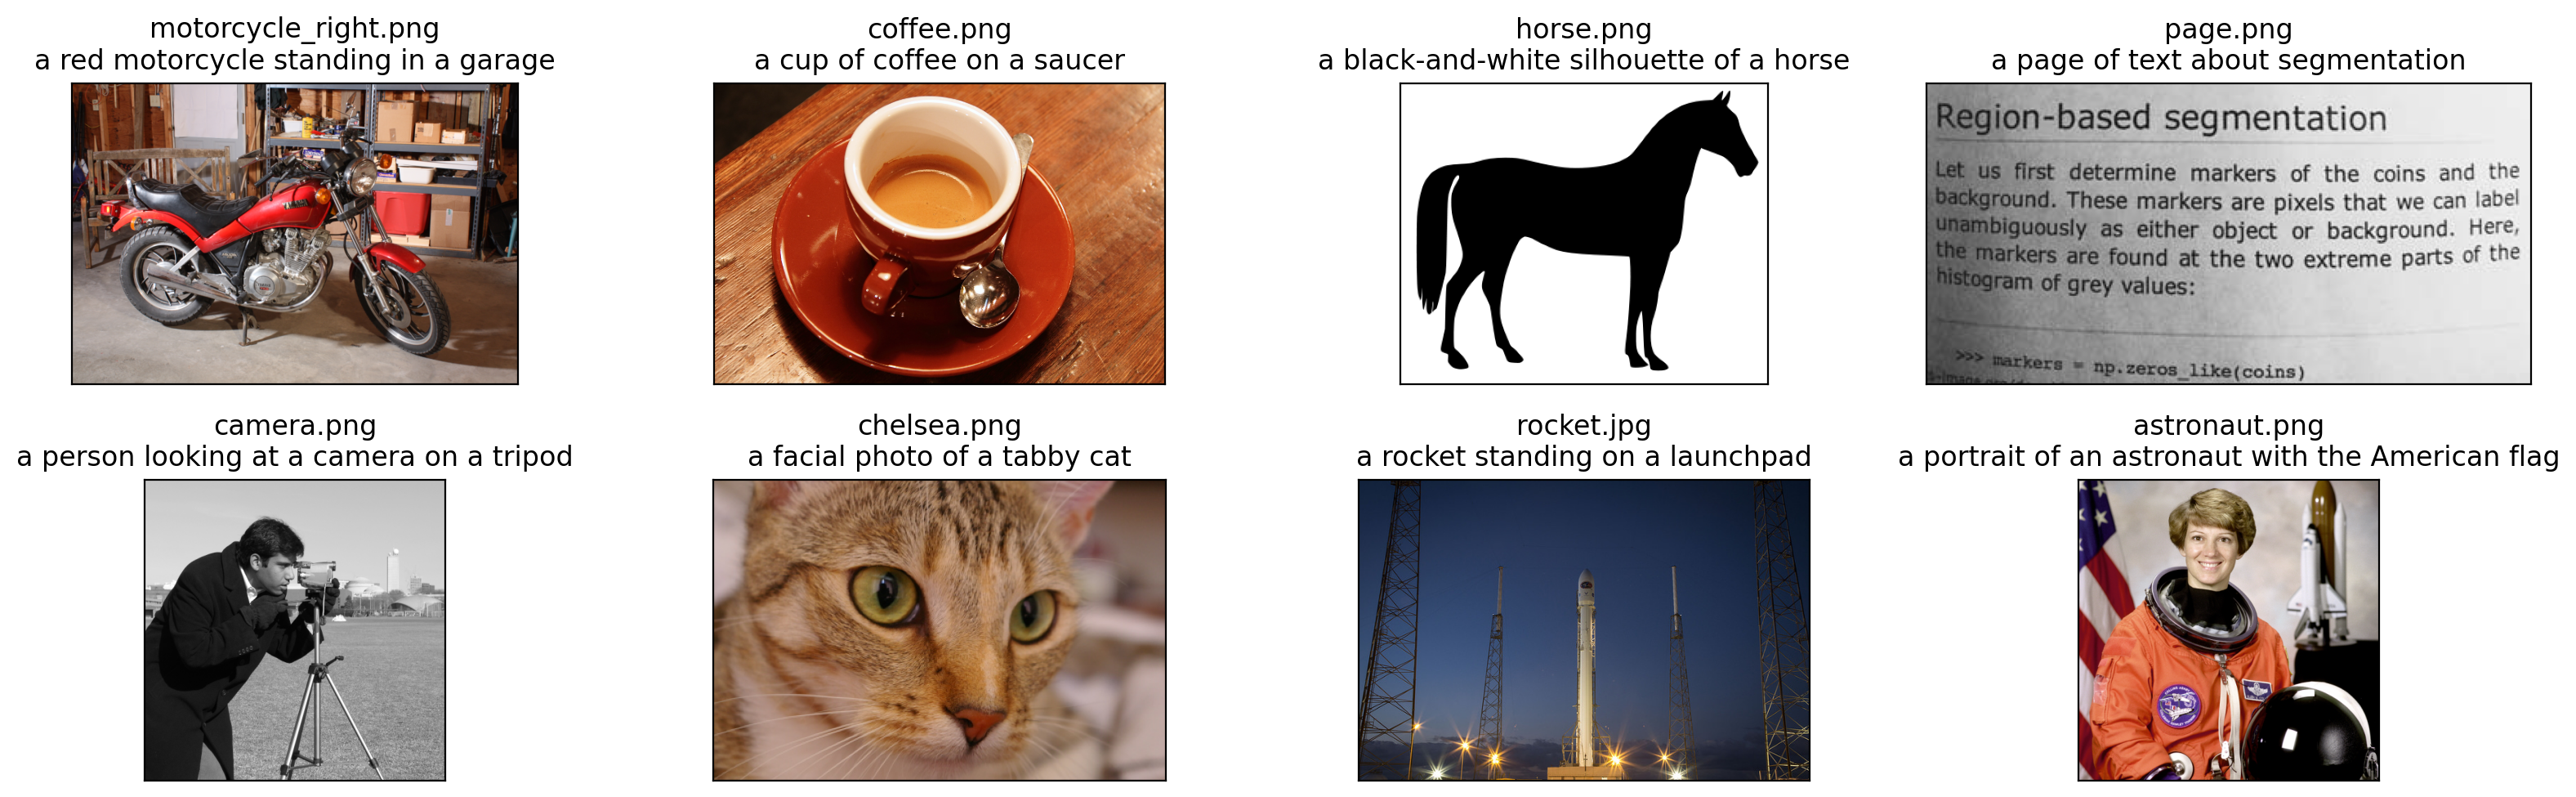

In [8]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

skimage.data.download_all(directory=None)
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(natural)", size=20)

## Performance of CLIP in medical domain

In [ ]:
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join("/content/drive/My Drive/data/pretrain_data/roco/train/radiology/images", filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)
for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)


# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# Fine-tuning CLIP on ROCO



In [ ]:
# dataset location
csv_file ="/content/drive/My Drive/data/roco-list.csv"
root_dir = "/content/drive/My Drive/data/pretrain_data/roco/train/radiology/images"
val_csv_file = "/content/drive/My Drive/data/local-val-list.csv"
val_root_dir = "/content/drive/My Drive/data/pretrain_data/roco/val/radiology/images"

# train options
seed = 42
batch_size = 16
image_size = 224
start_epoch = 0
epochs = 10
visual_encoder = "clip@ViT-B/16"
learning_rate = 3e-6
model_path = "/content/drive/My Drive/model_checkpoint_CLIP_ROCO" # set to the directory containing `checkpoint_##.tar`


In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torchvision
import datetime
import time
from tqdm import tqdm
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from torch.utils.data import Dataset
import random
import clip



class CLRDataset(Dataset):
    """Contrastive Learning Representations Dataset."""

    def __init__(self, csv_file, root_dir, transform=None, clip=False):
        self.clr_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.clip = clip

    def __len__(self):
        return len(self.clr_frame)

    def text_sampling(self, text):
        text = text.replace("\n", " ")
        text = text.split(".")
        if '' in text:
            text.remove('')
        text = random.choice(text)
        return text

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.clr_frame.iloc[idx, 0]
                                )
        if not os.path.exists(img_name):
            img_name=img_name.replace('train','val')
        image = Image.open(img_name)
        if not self.clip:
            image = image.convert('RGB')
        text = self.clr_frame.iloc[idx, 1]
        name = self.clr_frame.iloc[idx, 0]
        sample = {'image': image, 'text': text,'name':name}
        if self.clip:
            sample = self.transform(sample['image']), sample['text'],sample['name'] #self.text_sampling(sample['text'])
        elif self.transform:
            sample = self.transform(sample)

        return sample


def load_optimizer( model, lr=3e-6):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, epochs, eta_min=0, last_epoch=-1
    )
    return optimizer, scheduler


def train( train_loader, model, tokenizer, optimizer,truncation):
    loss_epoch = 0
    for step, (images, texts,name) in enumerate(train_loader):
        optimizer.zero_grad()
        x_v = images.to('cuda')
        x_u = tokenizer(list(texts), truncate=True).to('cuda')

        v,u=model(x_v,x_u)

        labels = torch.arange(batch_size, dtype=torch.long, device='cuda')

        loss_img = torch.nn.CrossEntropyLoss()
        loss_txt = torch.nn.CrossEntropyLoss()

        img_loss = loss_img(v,labels)
        text_loss = loss_txt(u,labels)

        loss = (img_loss + text_loss)/2

        loss.backward()
        optimizer.step()

        if step % 500 == 0:
            print(f"Step [{step}/{len(train_loader)}]\t Loss: {loss.item()}")

        loss_epoch += loss.item()
    return loss_epoch



def validate( val_loader, model, tokenizer, optimizer, truncation):

    with torch.no_grad():
        model.eval()
        loss_epoch = 0
        for step, (x_v, x_u) in enumerate(val_loader):
            x_v = x_v.to('cuda')
            x_u = tokenizer(list(x_u), truncate=True).to('cuda')

            v,u=model(x_v,x_u)

            labels = torch.arange(batch_size, dtype=torch.long, device='cuda')

            loss_img = torch.nn.CrossEntropyLoss()
            loss_txt = torch.nn.CrossEntropyLoss()

            img_loss = loss_img(v,labels)
            text_loss = loss_txt(u,labels)

            loss = (img_loss + text_loss)/2
            loss_epoch += loss.item()

    model.train()
    return loss_epoch


def main(gpu):

    is_master=True

    # set GPU device
    torch.cuda.set_device(gpu)
    torch.manual_seed(seed)
    np.random.seed(seed)

    # initialize model
    print("Initializing model... ", end="", flush=True)
    model, preprocess = clip.load(visual_encoder.split("@")[-1], device='cuda', jit=False)
    model.float()
    tokenizer=clip.tokenize
    train_fonction = train
    validate_fonction = validate

    # optimizer
    optimizer, scheduler = load_optimizer(model, lr=float(learning_rate))

    # initialize dataloader
    transform = preprocess
    print('Image_Transform',transform)
    train_dataset = CLRDataset(csv_file=csv_file,
                               root_dir=root_dir,
                               transform=transform,
                               clip = True
                               )

    val_dataset = CLRDataset(csv_file=val_csv_file,
                             root_dir=val_root_dir,
                             transform=transform,
                             clip = True
                             )

    train_sampler = None
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=(train_sampler is None),
        drop_last=True,
        num_workers=8,
        sampler=train_sampler,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        drop_last=True,
        num_workers=8
    )

    print("[DONE]\n")
    print("STARTING TRAINING")
    print('Start Time =', datetime.datetime.now().strftime("%H:%M:%S"), '\n')

    t0 = time.time()
    global_step = 0
    current_epoch = 0
    best_val_loss = np.inf

    for epoch in range(0, epochs):
        if epoch<2:
            if train_sampler is not None:
                train_sampler.set_epoch(epoch)

            lr = optimizer.param_groups[0]["lr"]
            loss_epoch = train_fonction(train_loader, model, tokenizer, optimizer,True)

        if is_master:
            val_loss = validate_fonction( val_loader, model, tokenizer, optimizer, True)
            if val_loss < best_val_loss:
                torch.save(model.state_dict(), os.path.join(model_path, "best_checkpoint.pth"))
                best_val_loss = val_loss

            epoch_counter = epoch - 0
            elapsed = time.time() - t0
            epoch_time = elapsed/(epoch_counter+1)
            remaining = (epochs - (epoch_counter+1))*epoch_time
            remaining = str(datetime.timedelta(seconds=round(remaining)))
            elapsed = str(datetime.timedelta(seconds=round(elapsed)))
            print(f'Epoch {epoch_counter+1}/{epochs} [{elapsed}<{remaining}, {round(epoch_time, 2)}s/epoch] {round((epoch_counter+1)/epochs*100, 1)}% loss: {loss_epoch / len(train_loader)}\t val_loss: {val_loss / len(val_loader)} lr: {lr}')

            current_epoch += 1


if not os.path.exists(model_path):
    os.makedirs(model_path)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
main(0)

## Performance of CLIP in medical domain(after fine-tuning on ROCO )

In [ ]:
#load checkpoint
model.load_state_dict(torch.load('/content/drive/My Drive/data/ViT-B-16_best_checkpoint_2.tar'))

#compute txt-img similarity again
original_images = []
images = []
texts = []
for filename in list(med_descriptions.keys()):
    image = Image.open(os.path.join(root_dir, filename+'.jpg'))
    original_images.append(image)
    images.append(preprocess(image))
    texts.append(med_descriptions[filename])
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features(medical)", size=20)